# Qubit Optimization for 3-qubit Ising model 

We will be comparing the PennyLane gradient descent optimizer with the optimizers in Tensorflow and PyTorch for this quantum system. The Ising model is an example of a system whose optimization landscape is non-convex and hence using gradient descent may not be the best strategy since the optimization can get stuck in local minimas. Quantum annealing (for example on a D-wave system) is one alternative that may have more success in finding the global ground state. 

The energy for this system is given by:
$$ H=-\sum_{<i,j>} J_{ij} \sigma_i \sigma_{j}$$

where each spin can be in +1 or -1 spin state and $J_{ij}$ are nearest neighbour coupling strengths.

For simplicity, we will assume that the first spin is always in up state (+1 eigenstate of Pauli-Z operator)

# PennyLane optimizer

In [1]:
# import PennyLane library

import pennylane as qml
from pennylane import numpy as np

In [2]:
# create our three devices. 

dev1 = qml.device('default.qubit', wires = 3)
dev2 = qml.device('default.qubit', wires = 3)
dev3 = qml.device('default.qubit', wires = 3)

In [3]:
# We use PennyLane's Rot(phi,theta,omega,wires) single-qubit operation

@qml.qnode(dev1)
def circuit1(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

# the expectation value of Pauli-Z is +1 for spin up and -1 for spin down.

Our cost function is the energy of the spin configuration which we will optimize using gradient descent.

Let the coupling matrix be J = [1,-1]

In [4]:
def cost1(var):
    spins = circuit1(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

Let's test these functions for the [1,-1,-1] spin configuration. 

Total energy for this Ising model should be

$$H = -1(J_1 s_1 \otimes s_2 + J_2 s_2 \otimes s3) = -1 [1 \times 1 \times (-1) + (-1) \times (-1) \times (-1)] = 2 $$


In [5]:
# You can easily guess the angles if you look at the Rot(phi,theta,omega)

t1 = np.array([0, np.pi, 0])    #spin 2 in -1 state
t2 = np.array([0, np.pi ,0])     #spin 3 in -1 state
print(cost1([t1, t2]))

2.0


Now we optimize using the PennyLane gradient descent optimizer

In [6]:
# initialize the parameters to some random values
np.random.seed(48)
pl1 = np.pi*(np.random.ranf(3))
pl2 = np.pi*(np.random.ranf(3))
var_init = np.array([pl1, pl2])
cost_init = cost1(var_init)
print(cost_init)

1.6909756656963424


The minimun energy should be -2 for the [1,1,-1] spin configuration which corresponds to the angles of [0,0,0] and [0,pi,0] for second and third spin respectively. 

In [7]:
gd = qml.GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost1, var)
    if (it + 1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost1(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost1(var), var),"\n")

Energy after step     5: -0.8526522 | Angles: [[0.05494731 0.82939429 0.89491775]
 [0.93926199 1.83649654 1.01935445]] 

Energy after step    10: -1.9846264 | Angles: [[0.05494731 0.00311615 0.89491775]
 [0.93926199 2.96607366 1.01935445]] 

Energy after step    15: -1.9999059 | Angles: [[5.49473067e-02 1.04553176e-06 8.94917751e-01]
 [9.39261991e-01 3.12787147e+00 1.01935445e+00]] 

Energy after step    20: -1.9999994 | Angles: [[5.49473067e-02 3.34668151e-10 8.94917751e-01]
 [9.39261991e-01 3.14052566e+00 1.01935445e+00]] 

Energy after step    25: -2.0000000 | Angles: [[5.49473067e-02 1.07117385e-13 8.94917751e-01]
 [9.39261991e-01 3.14150968e+00 1.01935445e+00]] 

Energy after step    30: -2.0000000 | Angles: [[5.49473067e-02 1.97210178e-17 8.94917751e-01]
 [9.39261991e-01 3.14158620e+00 1.01935445e+00]] 

Energy after step    35: -2.0000000 | Angles: [[5.49473067e-02 1.97210178e-17 8.94917751e-01]
 [9.39261991e-01 3.14159215e+00 1.01935445e+00]] 

Energy after step    40: -2.00000

# TensorFlow optimizer

In [8]:
# activate tenserflow 
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# to suppress warnings from being printed
tf.logging.set_verbosity(tf.logging.ERROR)

# check if the eager tenserflow execution is working
tf.enable_eager_execution()
print(tf.executing_eagerly())

/home/aroosa/conda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/aroosa/conda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/aroosa/conda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/aroosa/conda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: 

True


In [9]:
@qml.qnode(dev2, interface = 'tfe')
def circuit2(p1, p2):
        qml.Rot(p1[0], p1[1], p1[2], wires = 1)
        qml.Rot(p2[0], p2[1], p2[2], wires = 2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [10]:
def cost2(var):
    spins = circuit2(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [11]:
# let's test the functions for our known spin configuration [1,-1,-1]

t1 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)
t2 = tfe.Variable([0, np.pi, 0], dtype = tf.float64)

print(cost2([t1, t2]))

tf.Tensor(2.0, shape=(), dtype=float64)


In [12]:
# initialize the parameters to some random values
tf.random.set_random_seed(95)
tf1 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
tf2 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
var_init = [tf1, tf2]
cost_init = cost2(var_init)
print(cost_init)

tf.Tensor(1.6415624188526199, shape=(), dtype=float64)


In [13]:
# optimize using tensorflow optimizer

opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost2([tf1, tf2])
        grads = tape.gradient(loss, [tf1, tf2])

    opt.apply_gradients(zip(grads, [tf1, tf2]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf1,tf2])
            cost_tf.append (cost2([tf1,tf2]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost2([tf1,tf2]), [tf1.numpy(),tf2.numpy()]),"\n")

Energy after step     5:  0.4618767 | Angles: [array([1.10173765, 1.80656331, 2.34279535]), array([1.54188126, 2.92814608, 1.6940942 ])] 

Energy after step    10: -1.2836008 | Angles: [array([1.10173765, 0.86565832, 2.34279535]), array([1.54188126, 2.94348548, 1.6940942 ])] 

Energy after step    15: -1.8968016 | Angles: [array([1.10173765, 0.30970925, 2.34279535]), array([1.54188126, 3.0115427 , 1.6940942 ])] 

Energy after step    20: -1.9864099 | Angles: [array([1.10173765, 0.10287321, 2.34279535]), array([1.54188126, 3.06369378, 1.6940942 ])] 

Energy after step    25: -1.9977973 | Angles: [array([1.10173765, 0.0337903 , 2.34279535]), array([1.54188126, 3.09550928, 1.6940942 ])] 

Energy after step    30: -1.9995069 | Angles: [array([1.10173765, 0.01107875, 2.34279535]), array([1.54188126, 3.11437293, 1.6940942 ])] 

Energy after step    35: -1.9998576 | Angles: [array([1.10173765, 0.00363091, 2.34279535]), array([1.54188126, 3.12551865, 1.6940942 ])] 

Energy after step    40: -1

# PyTorch optimizer

In [14]:
import torch
from torch.autograd import Variable

In [15]:
@qml.qnode(dev3, interface = 'torch')
def circuit3(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [16]:
def cost3(var1,var2):
    spins = circuit3(var1, var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [17]:
# let's test the functions for our known spin configuration [1,-1,-1]

t1=torch.tensor([0, np.pi, 0])
t2=torch.tensor([0, np.pi ,0])
print(cost3(t1, t2))

tensor(2.0000, dtype=torch.float64)


In [18]:
torch.manual_seed(56)
pt1 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
pt2 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
var_init = [pt1, pt2]
cost_init = cost3(pt1, pt2)
print(cost_init)

tensor(1.6792, dtype=torch.float64, grad_fn=<SubBackward0>)


In [19]:
# optimizing using PyTorch optimizer 

opt = torch.optim.SGD(var_init, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost3(pt1, pt2)
    loss.backward()
    return loss


var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt1, pt2 = opt.param_groups[0]['params']
        costn = cost3(pt1, pt2)
        var_pt.append([pt1,pt2])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt1.detach().numpy(), pt2.detach().numpy()]),"\n")

Energy after step     5:  0.6846474 | Angles: [array([1.96323939, 1.93604492, 2.32767565]), array([0.65212549, 2.73080219, 2.4299563 ])] 

Energy after step    10: -1.0138530 | Angles: [array([1.96323939, 1.0136468 , 2.32767565]), array([0.65212549, 2.73225282, 2.4299563 ])] 

Energy after step    15: -1.8171995 | Angles: [array([1.96323939, 0.38483073, 2.32767565]), array([0.65212549, 2.85992571, 2.4299563 ])] 

Energy after step    20: -1.9686584 | Angles: [array([1.96323939, 0.13026452, 2.32767565]), array([0.65212549, 2.97097572, 2.4299563 ])] 

Energy after step    25: -1.9930403 | Angles: [array([1.96323939, 0.04302756, 2.32767565]), array([0.65212549, 3.04042222, 2.4299563 ])] 

Energy after step    30: -1.9980133 | Angles: [array([1.96323939, 0.01413292, 2.32767565]), array([0.65212549, 3.08179844, 2.4299563 ])] 

Energy after step    35: -1.9993550 | Angles: [array([1.96323939, 0.00463472, 2.32767565]), array([0.65212549, 3.10627578, 2.4299563 ])] 

Energy after step    40: -1

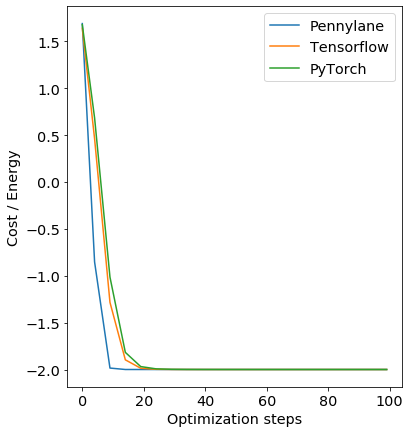

In [20]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)


params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

fig = plt.figure()
plt.plot(x, cost_gd, label = 'Pennylane')
plt.plot(x, cost_tf, label = 'Tensorflow')
plt.plot(x, cost_pt, label = 'PyTorch')
plt.xlabel("Optimization steps")
plt.ylabel("Cost / Energy")
plt.legend()
plt.show()


**So far, `random seeds` were set so that all the optimizers could find the global minimum.**

With different random intializations, you may see one or more of the optimizers getting stuck in local minima of energy (usually zero energy). 

Let's have a look at one such instance below.

In [21]:
dev4 = qml.device('default.qubit', wires = 3)
@qml.qnode(dev4)
def circuit4(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [22]:
def cost4(var):
    spins = circuit4(*var)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [23]:
# initialize the parameters to some random values
np.random.seed(139)
pl3 = np.pi*(np.random.ranf(3))
pl4 = np.pi*(np.random.ranf(3))
var_init = np.array([pl3, pl4])
cost_init = cost4(var_init)
print(cost_init)

0.086386657419815


In [24]:
gd = qml.GradientDescentOptimizer(0.4)

var = var_init
var_gd = [var]
cost_gd = [cost_init]

for it in range(100):
    var = gd.step(cost4, var)
    if (it + 1) % 5 == 0:
        var_gd.append(var)
        cost_gd.append (cost4(var))
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(it + 1, cost4(var), var),"\n")

Energy after step     5:  0.0035827 | Angles: [[1.54240383 2.29525545 2.93494919]
 [3.01266558 0.1040278  0.52144758]] 

Energy after step    10:  0.0001660 | Angles: [[1.54240383 2.29188659 2.93494919]
 [3.01266558 0.02242471 0.52144758]] 

Energy after step    15:  0.0000077 | Angles: [[1.54240383 2.29172947 2.93494919]
 [3.01266558 0.00484159 0.52144758]] 

Energy after step    20:  0.0000004 | Angles: [[1.54240383e+00 2.29172215e+00 2.93494919e+00]
 [3.01266558e+00 1.04539558e-03 5.21447581e-01]] 

Energy after step    25:  0.0000000 | Angles: [[1.54240383e+00 2.29172181e+00 2.93494919e+00]
 [3.01266558e+00 2.25722608e-04 5.21447581e-01]] 

Energy after step    30:  0.0000000 | Angles: [[1.54240383e+00 2.29172179e+00 2.93494919e+00]
 [3.01266558e+00 4.87382046e-05 5.21447581e-01]] 

Energy after step    35:  0.0000000 | Angles: [[1.54240383e+00 2.29172179e+00 2.93494919e+00]
 [3.01266558e+00 1.05235919e-05 5.21447581e-01]] 

Energy after step    40:  0.0000000 | Angles: [[1.5424038

In [25]:
dev5 = qml.device('default.qubit', wires = 3)
@qml.qnode(dev5, interface = 'tfe')
def circuit5(p1, p2):
        qml.Rot(p1[0], p1[1], p1[2], wires = 1)
        qml.Rot(p2[0], p2[1], p2[2], wires = 2)
        return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2)

In [26]:
def cost5(var):
    spins = circuit5(var[0], var[1])
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [27]:
# initialize the parameters to some random values
tf.random.set_random_seed(2)
tf3 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
tf4 = tfe.Variable(tf.random_uniform([3], 0, np.pi, dtype = tf.float64))
var_init = [tf3, tf4]
cost_init = cost5(var_init)
print(cost_init)

tf.Tensor(0.08468151715925465, shape=(), dtype=float64)


In [28]:
# optimize using tensorflow optimizer

opt = tf.train.GradientDescentOptimizer(learning_rate=0.1)

var = var_init
var_tf = [var]
cost_tf = [cost_init]

for i in range(100):
    with tf.GradientTape() as tape:
        loss = cost5([tf3, tf4])
        grads = tape.gradient(loss, [tf3, tf4])

    opt.apply_gradients(zip(grads, [tf3, tf4]), global_step=tf.train.get_or_create_global_step())
    if (i + 1) % 5 == 0:
            var_tf.append([tf3,tf4])
            cost_tf.append (cost5([tf3,tf4]))
            print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(i+1,cost5([tf3,tf4]), [tf3.numpy(),tf4.numpy()]),"\n")

Energy after step     5:  0.0373047 | Angles: [array([0.55047046, 2.48743518, 2.78322045]), array([0.04260889, 0.30783841, 0.75156933])] 

Energy after step    10:  0.0164729 | Angles: [array([0.55047046, 2.47675306, 2.78322045]), array([0.04260889, 0.20495997, 0.75156933])] 

Energy after step    15:  0.0072870 | Angles: [array([0.55047046, 2.47195078, 2.78322045]), array([0.04260889, 0.13644408, 0.75156933])] 

Energy after step    20:  0.0032265 | Angles: [array([0.55047046, 2.46980921, 2.78322045]), array([0.04260889, 0.0908294 , 0.75156933])] 

Energy after step    25:  0.0014292 | Angles: [array([0.55047046, 2.46885756, 2.78322045]), array([0.04260889, 0.06046369, 0.75156933])] 

Energy after step    30:  0.0006332 | Angles: [array([0.55047046, 2.46843533, 2.78322045]), array([0.04260889, 0.04024963, 0.75156933])] 

Energy after step    35:  0.0002806 | Angles: [array([0.55047046, 2.46824812, 2.78322045]), array([0.04260889, 0.02679345, 0.75156933])] 

Energy after step    40:  0

In [29]:
dev6 = qml.device('default.qubit', wires = 3)
@qml.qnode(dev6, interface = 'torch')
def circuit6(p1, p2):
    qml.Rot(p1[0], p1[1], p1[2], wires = 1)
    qml.Rot(p2[0], p2[1], p2[2], wires = 2)
    return qml.expval.PauliZ(0), qml.expval.PauliZ(1), qml.expval.PauliZ(2) 

In [30]:
def cost6(var1,var2):
    spins = circuit6(var1, var2)
    energy = -(1*spins[0]*spins[1]) - (-1*spins[1]*spins[2])
    return energy

In [31]:
torch.manual_seed(157)
pt3 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
pt4 = Variable((np.pi*torch.rand(3, dtype = torch.float64)), requires_grad = True)
var_init = [pt3, pt4]
cost_init = cost6(pt3, pt4)
print(cost_init)

tensor(0.0861, dtype=torch.float64, grad_fn=<SubBackward0>)


In [32]:
# optimizing using PyTorch optimizer 

opt = torch.optim.SGD(var_init, lr = 0.1)

def closure():
    opt.zero_grad()
    loss = cost6(pt3, pt4)
    loss.backward()
    return loss


var_pt = [var_init]
cost_pt = [cost_init]

for j in range(100):
    opt.step(closure)
    if (j + 1) % 5 == 0:
        pt3, pt4= opt.param_groups[0]['params']
        costn = cost6(pt3, pt4)
        var_pt.append([pt3,pt4])
        cost_pt.append(costn)
        print('Energy after step {:5d}: {: .7f} | Angles: {}'.format(j+1,costn, [pt3.detach().numpy(), pt4.detach().numpy()]),"\n")

Energy after step     5: -0.2897305 | Angles: [array([0.24952418, 1.24328243, 1.70128367]), array([1.14114072, 1.47128322, 2.07346266])] 

Energy after step    10: -0.7774905 | Angles: [array([0.24952418, 0.81764693, 1.70128367]), array([1.14114072, 1.70800868, 2.07346266])] 

Energy after step    15: -1.3514536 | Angles: [array([0.24952418, 0.43468725, 1.70128367]), array([1.14114072, 2.08291253, 2.07346266])] 

Energy after step    20: -1.7418127 | Angles: [array([0.24952418, 0.18328493, 1.70128367]), array([1.14114072, 2.45196744, 2.07346266])] 

Energy after step    25: -1.9081490 | Angles: [array([0.24952418, 0.06663017, 1.70128367]), array([1.14114072, 2.71988798, 2.07346266])] 

Energy after step    30: -1.9679099 | Angles: [array([0.24952418, 0.02268646, 1.70128367]), array([1.14114072, 2.88959546, 2.07346266])] 

Energy after step    35: -1.9888020 | Angles: [array([0.24952418, 0.0075359 , 1.70128367]), array([1.14114072, 2.99217894, 2.07346266])] 

Energy after step    40: -1

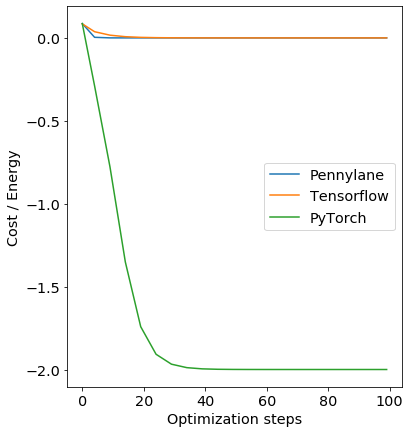

In [33]:
x = [0]
for k in range(100):
    if (k + 1) % 5 == 0:
        x.append(k)
        
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 7),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

plt.plot(x, cost_gd, label = 'Pennylane')
plt.plot(x, cost_tf, label = 'Tensorflow')
plt.plot(x, cost_pt, label = 'PyTorch')
plt.xlabel("Optimization steps")
plt.ylabel("Cost / Energy")
plt.legend()
plt.show()


When we initialize close to zero, the optimizers are more likely to get stuck in the local minimum. 

Try it yourself! Download and run this file with different initialization parameters and see how the results change.

**Do not forget to restart the kernel before rerunning the file!** You will find the option in the `Kernel` tab in the top bar. This makes sure all the variables are cleared up and the optimizers are restarted.  